In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import pycuda.autoinit
from pycuda.driver import In, Out, Context
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import cpuinfo
import os
from pycuda.tools import make_default_context
from pycuda import driver, compiler, tools, gpuarray
warnings.filterwarnings('ignore')

In [10]:
def show_images(images, names=None):
    assert (len(images) == len(names) if names else True)
    
    fig, axs = plt.subplots(1, len(images), figsize=(8, 6))

    for idx, image in enumerate(images):
        if len(image.shape) > 2:
            axs[idx].imshow(image)
        else:
            axs[idx].imshow(image, cmap='gray')
    
        if names:
            axs[idx].set_title(names[idx])

        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

Размер изображения: (1274, 707)


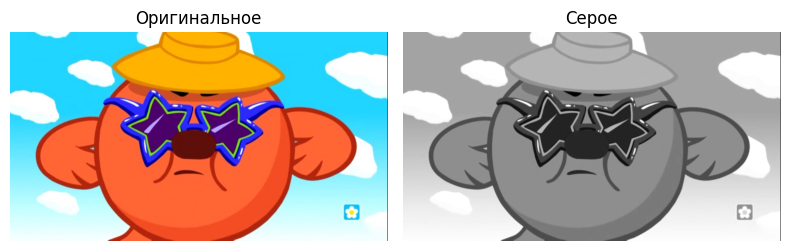

In [11]:
# Откроем и переформатируем изображение в нужный формат
image_path = '../input/hpc-lab/photo1_lab1.jpg'
save_path = '/kaggle/working/'
image = Image.open(image_path)
gray_image = image.convert('L')
gray_image.save(save_path + 'gray_image.bmp')
print('Размер изображения:', gray_image.size)

image = np.array(image)
gray_image = np.array(gray_image)

# выведем изображения
show_images([image, gray_image], ['Оригинальное', 'Серое'])

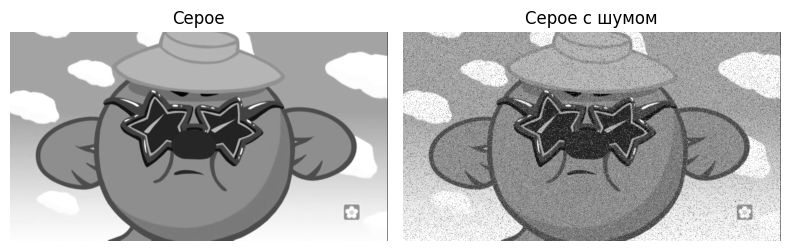

In [12]:
# Добавим шум на изображение
p = 0.1 # Вероятность шума
noise_mask = (np.random.rand(*gray_image.shape) < p) # Пиксели, которые будут изменены

noise_image = gray_image.copy()
noise_image[noise_mask] = (np.random.randint(0, 2, size=gray_image.shape, dtype='uint8') * 255)[noise_mask]

# Выведем результаты
show_images([gray_image, noise_image], ['Серое', 'Серое с шумом'])

# Сохраним изображение с шумом
Image.fromarray(noise_image).save(save_path + 'noise_image.bmp')

In [13]:
def median_filter(image):
    kernel = """
        #include <cuda_runtime.h>
        #include <device_launch_parameters.h>

        __device__ void bubble_sort(unsigned char arr[], int n) {
            for (int i = 0; i < n - 1; i++) {
                for (int j = 0; j < n - i - 1; j++) {
                    if (arr[j] > arr[j + 1]) {
                        unsigned char temp = arr[j];
                        arr[j] = arr[j + 1];
                        arr[j + 1] = temp;
                    }
                }
            }
        }

        __global__ void median_filter(const unsigned char* input, unsigned char* output, int width, int height) {
            int x = blockIdx.x * blockDim.x + threadIdx.x;
            int y = blockIdx.y * blockDim.y + threadIdx.y;
    
            if (x < width && y < height) {
                unsigned char window[9];
                int count = 0;

                for (int dy = -1; dy <= 1; ++dy) {
                    for (int dx = -1; dx <= 1; ++dx) {
                        int nx = min(max(x + dx, 0), width - 1);
                        int ny = min(max(y + dy, 0), height - 1);
                        window[count++] = input[ny * width + nx];
                    }
                }

                bubble_sort(window, 9);
                output[y * width + x] = window[4];
            }
        }
    """

    module = SourceModule(kernel)
    median_filter_kernel = module.get_function("median_filter")
    height, width = image.shape
    image_gpu = cuda.mem_alloc(image.nbytes)
    filtered_gpu = cuda.mem_alloc(image.nbytes)

    cuda.memcpy_htod(image_gpu, image)

    BLOCK = 16
    block_size = (BLOCK, BLOCK, 1)
    grid_size = ((width + block_size[0] - 1) // block_size[0],
                 (height + block_size[1] - 1) // block_size[1])
    median_filter_kernel(image_gpu, filtered_gpu, np.int32(width), np.int32(height),
                         block=block_size, grid=grid_size)
    filtered = np.empty_like(image)
    cuda.memcpy_dtoh(filtered, filtered_gpu)

    image_gpu.free()
    filtered_gpu.free()

    return filtered

GPU: Tesla P100-PCIE-16GB
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz

Время выполнения на GPU: 0.123


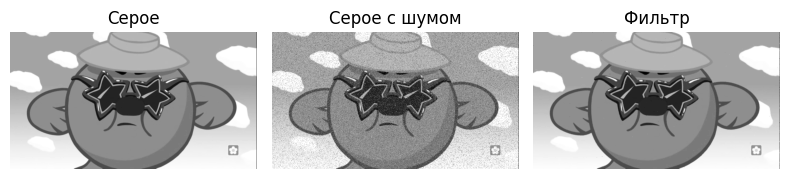

In [23]:
print(f'GPU: {tools.make_default_context().get_device().name()}')
print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')
print()

GPU_START = time.time()
filtered_image = median_filter(noise_image)
GPU_TIME = time.time() - GPU_START

print(f'Время выполнения на GPU: {GPU_TIME:.3f}')

show_images([gray_image, noise_image, filtered_image], ['Серое', 'Серое с шумом', 'Фильтр'])

Image.fromarray(filtered_image).save(save_path + 'filtered_image.bmp')

In [24]:
(gray_image - filtered_image != 0).sum()

133811